In [1]:
%matplotlib inline
import kornia
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from kornia.feature import *
from kornia.geometry import *

from kornia import tensor_to_image as tti

In [2]:
def visualize_LAF(img, LAF, img_idx = 0):
    x, y = kornia.feature.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(kornia.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return

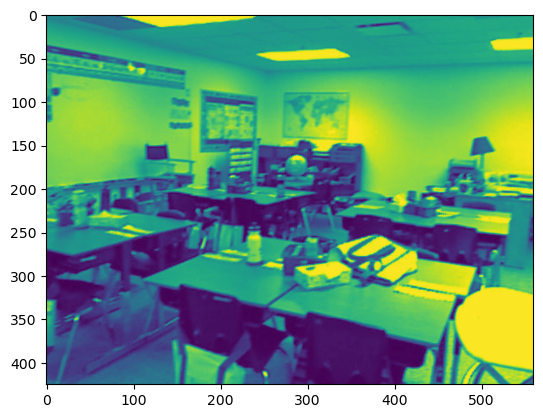

In [25]:
img = Image.open('../images/a1.png')
timg = kornia.utils.image_to_tensor(np.array(img), keepdim=False).float()/255.
timg = kornia.color.rgb_to_grayscale(timg)
plt.imshow(kornia.utils.tensor_to_image(timg[0]))

In [16]:
timg.shape

torch.Size([1, 3, 425, 560])

In [26]:
SP = ScalePyramid(3, 1.6, 10)

pyr, sigmas, scales = SP (timg)
print (len(pyr), pyr[0].shape)

6 torch.Size([1, 1, 6, 425, 560])


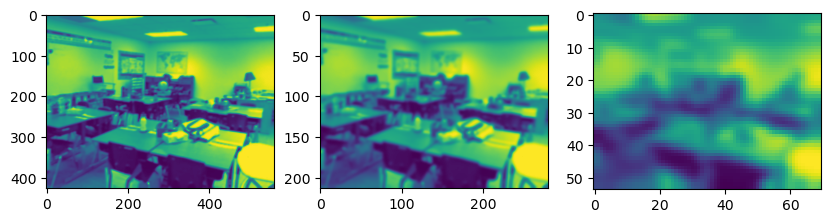

In [27]:
fig, axes = plt.subplots(1,3, figsize=(10,6))
ax = axes[0]
ax.imshow(tti(pyr[0][0,0,0]))
ax = axes[1]
ax.imshow(tti(pyr[1][0,0,0]))
ax = axes[2]
ax.imshow(tti(pyr[3][0,0,0]))
current_level = pyr[1]

In [24]:
pyr[0].shape

torch.Size([1, 3, 6, 425, 560])

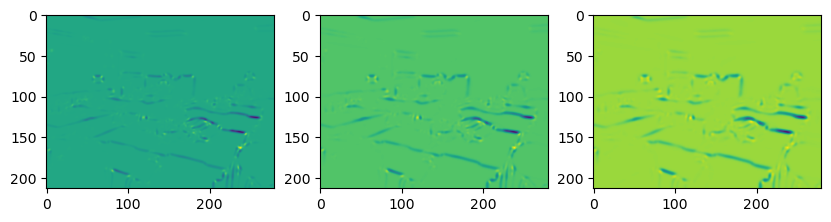

In [28]:
resp = kornia.feature.responses.CornerHarris(0.05)

fig, axes = plt.subplots(1,3, figsize=(10,6))

cornerness = resp(current_level[0])
for i in range(3):
    ax = axes[i]
    ax.imshow(tti(cornerness[0,i]))

In [29]:
nms1 = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, height, width)
                                       stride=(1,1,1), # stride (scale, height, width)
                                       padding=(1, 1, 1),
                                       temperature=0.1) 

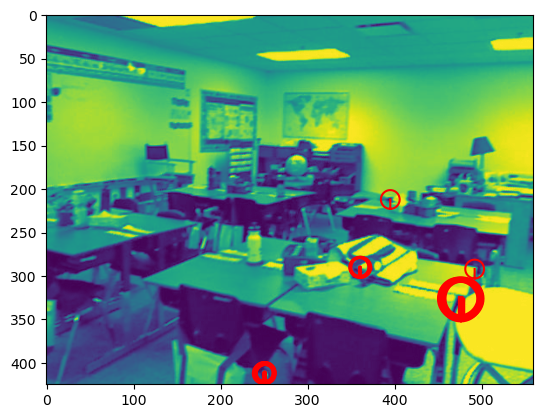

In [30]:
#Lets detect Harris corners
n_feats = 40
mr_size = 6.0 
nms1 = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, height, width)
                                       stride=(1,1,1), # stride (scale, height, width)
                                       padding=(1, 1, 1),
                                       temperature=0.1) # nms windows size (scale, height, width)

harris_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms1,
                                    mr_size=mr_size)
lafs, resps = harris_local_detector(timg)
visualize_LAF(timg, lafs)

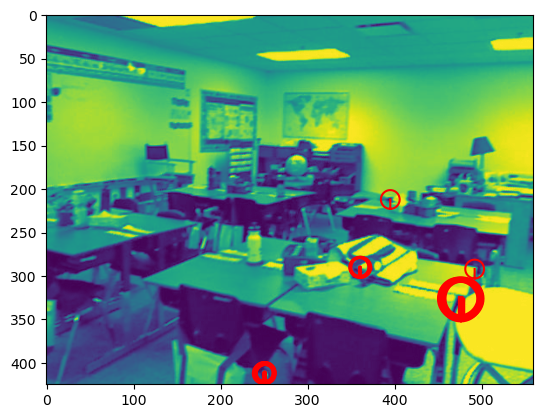

In [31]:
mr_size = 6.0 
nms1 = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, height, width)
                                       stride=(1,1,1), # stride (scale, height, width)
                                       padding=(1, 1, 1),
                                       temperature=0.1,
                                       strict_maxima_bonus=100.) # nms windows size (scale, height, width)

harris_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms1,
                                    mr_size=mr_size)
lafs, resps = harris_local_detector(timg)
visualize_LAF(timg, lafs)

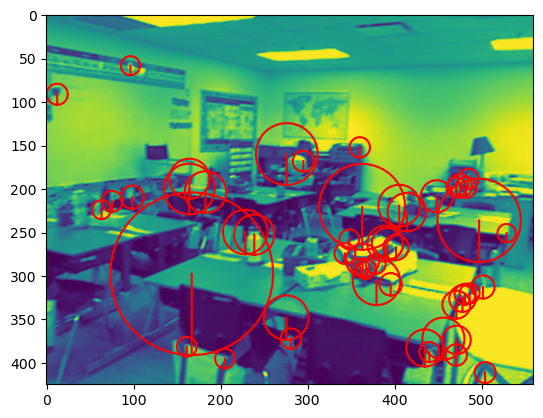

In [36]:
#Lets detect Harris corners w/o duplicates
n_feats = 50
mr_size = 6.0 
nms = kornia.geometry.ConvQuadInterp3d(10, 2e-4)

harris_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms,
                                    mr_size=mr_size)

lafs, resps = harris_local_detector(timg)
visualize_LAF(timg,lafs)

In [39]:
resps.shape

torch.Size([1, 50])

/var/folders/xl/510yskh50hj_222x1q55k8_c0000gn/T/ipykernel_37586/3157828136.py:6: DeprecationWarning: `LAFAffineShapeEstimator` default behaviour is changed and now it does preserve original LAF orientation. Make sure your code accounts for this.
  aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),


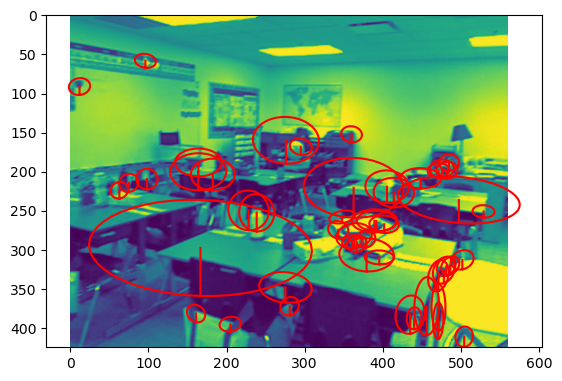

In [33]:
# What about Harris-Affine features?
harris_affine_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=kornia.feature.CornerHarris(0.05),
                                    nms_module=nms,
                                    mr_size=mr_size,
                                    aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),
                                    minima_are_also_good=False)
lafs, resps = harris_affine_local_detector(timg)
visualize_LAF(timg,lafs)

/var/folders/xl/510yskh50hj_222x1q55k8_c0000gn/T/ipykernel_37586/2078919410.py:6: DeprecationWarning: `LAFAffineShapeEstimator` default behaviour is changed and now it does preserve original LAF orientation. Make sure your code accounts for this.
  aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),


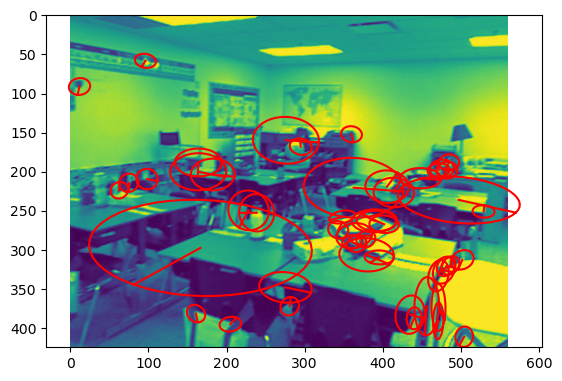

In [34]:
# Now lets also detect feature orientation
harris_affine_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=kornia.feature.CornerHarris(0.05),
                                    nms_module=nms,
                                    mr_size=mr_size,
                                    aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),
                                    ori_module=kornia.feature.LAFOrienter(patch_size=19))

lafs, resps = harris_affine_local_detector(timg)
visualize_LAF(timg,lafs)

In [40]:
descriptor = kornia.feature.SIFTDescriptor(32)

patches =  kornia.feature.extract_patches_from_pyramid(timg, lafs)
B, N, CH, H, W = patches.size()
# Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
# So we need to reshape a bit :) 
descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
print (descs.shape)
print (descs[0, 0])

torch.Size([1, 50, 128])
tensor([4.1112e-03, 1.7377e-02, 2.7283e-02, 4.7758e-02, 3.6962e-02, 7.6646e-02,
        2.3549e-02, 6.8903e-03, 3.4684e-02, 1.1447e-01, 2.8251e-02, 1.7549e-02,
        4.6159e-03, 3.6944e-02, 8.4300e-02, 6.9085e-02, 9.8636e-03, 1.7263e-02,
        7.2765e-02, 1.5544e-01, 3.5440e-02, 1.9855e-01, 1.9855e-01, 1.5097e-01,
        3.0094e-02, 9.6275e-02, 3.9300e-02, 3.3698e-03, 2.6924e-02, 4.5823e-02,
        1.7642e-01, 7.2037e-02, 1.9855e-01, 5.5103e-02, 6.1510e-02, 1.6045e-01,
        5.2727e-02, 1.3452e-01, 1.9855e-01, 1.5844e-01, 6.7655e-02, 4.3273e-02,
        2.6913e-02, 8.4706e-03, 6.9738e-02, 1.4558e-01, 1.0735e-01, 2.7228e-02,
        1.5588e-01, 7.8811e-02, 1.7766e-02, 2.2238e-02, 3.5994e-02, 3.2200e-02,
        1.9015e-02, 5.1924e-02, 1.0895e-01, 2.7579e-02, 8.4274e-03, 6.7496e-02,
        8.1549e-02, 1.0194e-01, 4.0875e-02, 2.8939e-02, 6.4398e-02, 8.3099e-02,
        2.0830e-02, 8.4555e-03, 2.9072e-02, 3.3859e-02, 1.4162e-02, 1.1621e-01,
        1.5877e